In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# !!! Modify this to match the name of the csv file of the patients you generated
file_path = "llm_patients_040725.csv"

In [3]:
# =============================================================================
# Hard-coded Demographic Distributions
# =============================================================================

""" This data is the same as the demographic distributions from the llm_patient_creator.ipynb file. """
# split distributions to a .py file?

# Age distribution (averaged for men & women).
AGE_WEIGHTS_MEN = np.array([0.2979, 0.1916, 0.1557, 0.2266, 0.1282])
AGE_WEIGHTS_WOMEN = np.array([0.2861, 0.1683, 0.1483, 0.2343, 0.1630])

# Relationship status percentages by age group: (18-25, 26-35, 36-45, 46-60, 60+)
RELATIONSHIP_STATUS_DISTRIBUTIONS = [
    [69.26, 23.09,  7.40,  0.25,  0.00],  # 18-25
    [31.73, 10.58, 55.35,  2.15,  0.20],  # 26-35
    [10.88,  3.63, 76.00,  8.15,  1.35],  # 36-45
    [ 9.00,  3.00, 68.33, 15.33,  8.17],  # 46-60
    [11.25,  3.75, 54.17,  8.83, 33.50],  # 60+
]

# Probabilities of being "in a family" & "with children," by 4 age bins (0-24, 25-34, 35-44, 45-54).
IN_FAMILY = [
    [0.0756, 0.0701],  # female, male (0-24)
    [0.5102, 0.4765],  # female, male (25-34)
    [0.8340, 0.8178],  # female, male (35-44)
    [0.8426, 0.8557],  # female, male (45+)
]
WITH_CHILDREN = [
    [0.6997, 0.3003],  # yes, no  (0-24)
    [0.5193, 0.4807],  # yes, no  (25-34)
    [0.2056, 0.7944],  # yes, no  (35-44)
    [0.1771, 0.8229],  # yes, no  (45+)
]

SEX_WEIGHTS = [0.51, 0.49]
SEX_LABELS = ["Male", "Female"]

AGE_ORDER = ["18-25", "26-35", "36-45", "46-60", "60+"]

RELATIONSHIP_ORDER = ["Single", "Long-term relationship",
                          "Married/Common-Law", "Divorced/Separated", "Widowded"]


DISABILITY_CATEGORIES = [
        "Mental-health related", "Pain-related", "Seeing",
        "Learning", "Memory", "Mobility", "Flexibility",
        "Hearing", "Dexterity", "Developmental"
    ]

ETHNICITY_PROBABILITY = [0.0243, 0.0334, 0.4313, 0.2328, 0.1417, 0.0763, 0.0198, 0.0158, 0.0251]

ETHNICITY_ORDER = ["Indigenous", "Middle Eastern", "European", 
                   "East Asian", "South Asian", "Southeast Asian", 
                   "Latin American", "African", "Other"]

ETHNICITY_CATEGORIES = {
    "Indigenous": [
        "Indigenous"
    ],
    "Middle Eastern": ["Persian - Iran", "Hebrew - Israel"],
    "European": [
        "Czech - Czech Republic", "Danish - Denmark", "German - Austria", "German - Switzerland", "German - Germany",
        "Greek - Greece", "English - Canada", "English - United States", "English - United Kingdom", "English - Ireland",
        "Spanish - Spain", "Finnish - Finland", "French - Canada", "French - Switzerland", "French - France",
        "Croatian - Croatia", "Hungarian - Hungary", "Armenian - Armenia", "Italian - Italy", "Dutch - Belgium",
        "Dutch - Netherlands", "Norwegian - Norway", "Polish - Poland", "Portuguese - Portugal", "Romanian - Romania",
        "Russian - Russia", "Slovak - Slovakia", "Swedish - Sweden", "Ukrainian - Ukraine"
    ],
    "East Asian": [
        "Japanese - Japan", "Korean - South Korea",
        "Chinese - China", "Chinese - Taiwan"
    ],
    "South Asian": [
        "English - India", "Hindi - India", "Nepali - Nepal",
        "Tamil - India", "Bengali - Bangladesh", "English - Bangladesh",
        "Georgian - Georgia", "Azerbaijani - Azerbaijan"
    ],
    "Southeast Asian": [
        "English - Malaysia", "English - Philippines", "Filipino - Philippines",
        "Indonesian - Indonesia", "Thai - Thailand", "Tagalog - Philippines",
        "Vietnamese - Vietnam"
    ],
    "Latin American": [
        "Spanish - Argentina", "Spanish - Chile", "Spanish - Colombia",
        "Spanish - Mexico", "Portuguese - Brazil"
    ],
    "African": ["Zulu - South Africa"],
    "Other": ["English - Australia", "English - New Zealand"],
}

In [4]:
# =============================================================================
# Statistical Tests
# =============================================================================

def binomial_p_value(n, p, observed_count, tail='right'):
    """
    Compute the p-value for a binomial distribution using a normal approximation.
    """
    expected = n * p
    print("expected:", expected)
    sigma = np.sqrt(n * p * (1 - p))
    print("sigma:", sigma)
    print("obs:", observed_count)
    z_score = (observed_count - expected) / sigma
    print("z:", z_score)
    
    if observed_count > expected:
        print("right")
        print("observed:", observed_count)
        print("expected:", expected)
        p_value = 1 - stats.norm.cdf(z_score)
    else:  # left tail
        print("left")
        p_value = stats.norm.cdf(z_score)
    
    return z_score, p_value

def multinomial_p_value(observed_counts, expected_probs):
    """
    Compute the p-value for a multinomial distribution using the chi-square test.
    """
    total_n = sum(observed_counts)
    expected_counts = np.array(expected_probs) * total_n
    print("expected:", expected_counts)
    print(observed_counts,expected_counts)
    chi_square_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
    # chi_square_stat = 0
    # p_value = 0
    return chi_square_stat, p_value

In [5]:
# =============================================================================
# Analysis and Plotting
# =============================================================================

def analyze_and_plot(df, column, expected_probs, title, chart_type='bar', order=None):
    """
    Perform statistical analysis and plot distributions for a given categorical column.
    """

    # If an order is provided, reindex the observed counts accordingly
    if order is not None:
        observed_counts = df[column].value_counts().reindex(order, fill_value=0)
    else:
        observed_counts = df[column].value_counts().sort_index()
        
    print("counts:", observed_counts)
    observed_probs = observed_counts / observed_counts.sum()
    print("probs:", observed_probs)
    
    # Normalize probabilities
    expected_probs = np.array(expected_probs) / np.sum(expected_probs)
    observed_probs = observed_counts / observed_counts.sum()
    
    if len(expected_probs) == 2:
        # Binomial test
        print(observed_counts.sum(), expected_probs[1], observed_counts.iloc[1])
        z_score, p_value = binomial_p_value(observed_counts.sum(), expected_probs[1], observed_counts.iloc[1])
        print(f"{title} - Z-score: {z_score:.2f}, P-value: {p_value:.4f}")
    else:
        # Multinomial test
        chi_square_stat, p_value = multinomial_p_value(observed_counts.values, expected_probs)
        print(f"{title} - Chi-Square: {chi_square_stat:.2f}, P-value: {p_value:.4f}")
    
    # Plot distribution
    plt.figure(figsize=(8, 5))
    if chart_type == 'bar':
        sns.barplot(x=observed_counts.index, y=observed_probs, palette='pastel')
        plt.ylabel('Proportion')
    elif chart_type == 'pie':
        plt.pie(observed_probs, labels=observed_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    
    plt.title(title)
    plt.show()

In [6]:
# =============================================================================
# Helper Functions
# =============================================================================

def categorize_ethnicity(ethnicity):
    for category, values in ETHNICITY_CATEGORIES.items():
         if ethnicity in values:
            return category
    return "Uncategorized"


def compute_expected_disability(row):
    """
    Compute the expected disability probabilities for each disability type.
    For each patient, we first compute the probability of being disabled based on
    age and sex, and then distribute that probability among the 10 disability types.
    This returns a Series where each value is the expected contribution for that disability.
    """
    # Determine sex and age index
    sex = row.get("Sex", "Male")
    age = row.get("Age", 30)
    sex_idx = 0 if sex == "Male" else 1
    if age < 25:
        age_idx = 0
    elif age < 65:
        age_idx = 1
    else:
        age_idx = 2

    # Compute the probability of being disabled based on hard-coded matrices
    if sex_idx == 0:  # Male
        disability_probability_total = [0.158, 0.211, 0.389]
    else:  # Female
        disability_probability_total = [0.247, 0.269, 0.418]
    
    p_disabled = disability_probability_total[age_idx]

    # Normalize the distribution for the 10 disability types
    s = 38.6 + 61.8 + 27.4 + 20.7 + 18.2 + 39.2 + 40.3 + 20.7 + 18.4 + 5.7
    
    disability_probability_types = [38.6/s, 61.8/s,
                                   27.4/s, 20.7/s,
                                   18.2/s, 39.2/s,
                                   40.3/s, 20.7/s,
                                   18.4/s, 5.7/s]
    
    # Each disability category’s expected probability is:
    # p(disabled) * (normalized probability for that type)
    expected = {cat: p_disabled * prob for cat, prob in zip(DISABILITY_CATEGORIES, disability_probability_types)}
    return pd.Series(expected)

def categorize_age(age):
    """
    Categorize age into groups:
    18-25, 26-35, 36-45, 46-60, 60+.
    """
    if age < 18:
        return "Under 18"
    elif 18 <= age <= 25:
        return "18-25"
    elif 26 <= age <= 35:
        return "26-35"
    elif 36 <= age <= 45:
        return "36-45"
    elif 46 <= age <= 60:
        return "46-60"
    else:
        return "60+"

def compute_expected_age_probs(df):
    """
    Compute overall expected age probabilities using provided weights and the sex distribution in df.
    """
    
    # Calculate proportion of males and females in the dataset
    sex_counts = df['Sex'].value_counts(normalize=True)
    prop_male = sex_counts.get("Male", 0)
    prop_female = sex_counts.get("Female", 0)
    
    overall_expected = prop_male * AGE_WEIGHTS_MEN + prop_female * AGE_WEIGHTS_WOMEN
    print("Expected age probabilities:", overall_expected)
    return overall_expected, AGE_ORDER


=== Statistical Tests and Graphs ===

counts: Sex
Female    518
Male      482
Name: count, dtype: int64
probs: Sex
Female    0.518
Male      0.482
Name: count, dtype: float64
1000 0.49 482
expected: 490.0
sigma: 15.8082257068907
obs: 482
z: -0.5060656488800545
left
Sex Distribution - Z-score: -0.51, P-value: 0.3064


/tmp/ipykernel_1320601/1331104002.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=observed_counts.index, y=observed_probs, palette='pastel')


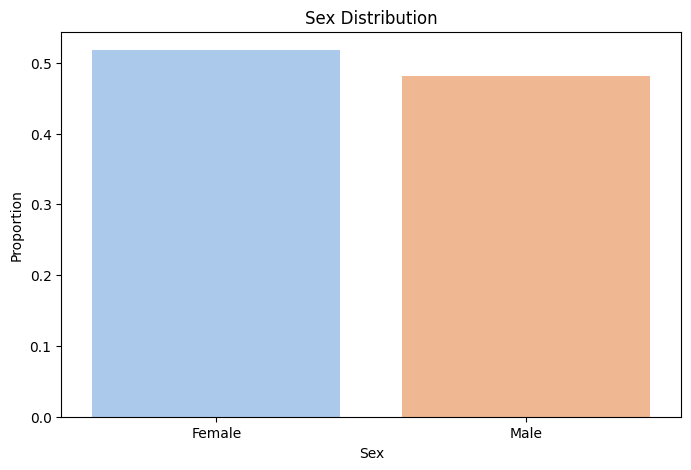

Expected age probabilities: [0.2917876 0.1795306 0.1518668 0.2305886 0.1462264]
counts: Age_Category
18-25    295
26-35    171
36-45    140
46-60    247
60+      147
Name: count, dtype: int64
probs: Age_Category
18-25    0.295
26-35    0.171
36-45    0.140
46-60    0.247
60+      0.147
Name: count, dtype: float64
expected: [291.7876 179.5306 151.8668 230.5886 146.2264]
[295 171 140 247 147] [291.7876 179.5306 151.8668 230.5886 146.2264]
Age Distribution - Chi-Square: 2.54, P-value: 0.6375


/tmp/ipykernel_1320601/1331104002.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=observed_counts.index, y=observed_probs, palette='pastel')


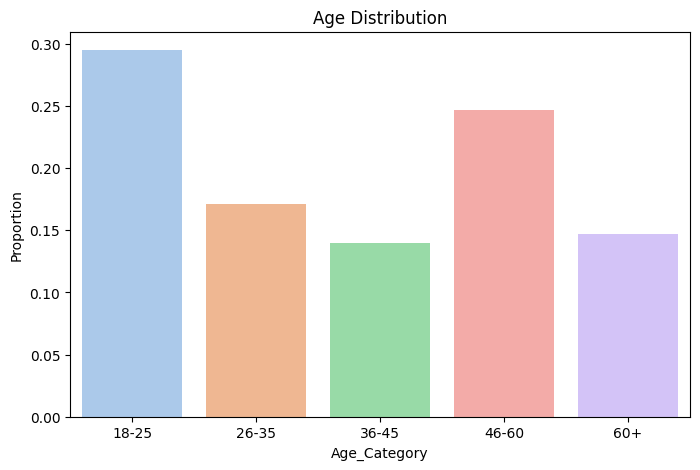

/tmp/ipykernel_1320601/1331104002.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=observed_counts.index, y=observed_probs, palette='pastel')


counts: Ethnicity_Category
Indigenous          25
Middle Eastern      34
European           416
East Asian         228
South Asian        149
Southeast Asian     69
Latin American      32
African             15
Other               32
Name: count, dtype: int64
probs: Ethnicity_Category
Indigenous         0.025
Middle Eastern     0.034
European           0.416
East Asian         0.228
South Asian        0.149
Southeast Asian    0.069
Latin American     0.032
African            0.015
Other              0.032
Name: count, dtype: float64
expected: [ 24.28785607  33.38330835 431.08445777 232.68365817 141.62918541
  76.26186907  19.79010495  15.79210395  25.08745627]
[ 25  34 416 228 149  69  32  15  32] [ 24.28785607  33.38330835 431.08445777 232.68365817 141.62918541
  76.26186907  19.79010495  15.79210395  25.08745627]
Ethnicity Distribution - Chi-Square: 11.21, P-value: 0.1902


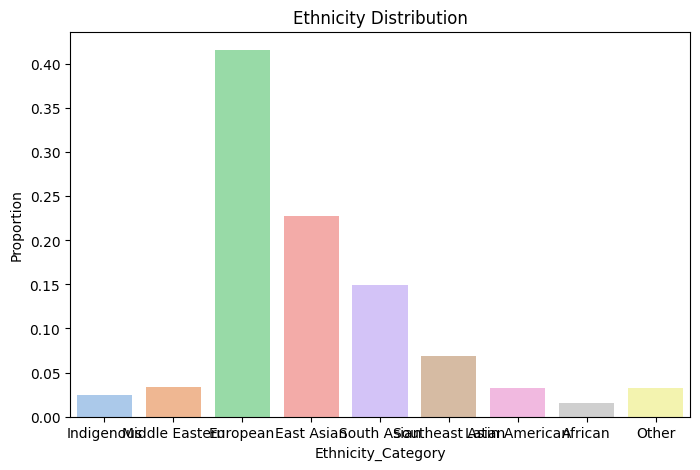

counts: Disability
Mental-health related    12
Pain-related             24
Seeing                    9
Learning                  2
Memory                    2
Mobility                  5
Flexibility              10
Hearing                  12
Dexterity                 2
Developmental             0
Name: count, dtype: int64
probs: Disability
Mental-health related    0.153846
Pain-related             0.307692
Seeing                   0.115385
Learning                 0.025641
Memory                   0.025641
Mobility                 0.064103
Flexibility              0.128205
Hearing                  0.153846
Dexterity                0.025641
Developmental            0.000000
Name: count, dtype: float64
expected: [10.34639175 16.56494845  7.3443299   5.54845361  4.87835052 10.50721649
 10.80206186  5.54845361  4.93195876  1.52783505]
[12 24  9  2  2  5 10 12  2  0] [10.34639175 16.56494845  7.3443299   5.54845361  4.87835052 10.50721649
 10.80206186  5.54845361  4.93195876  1.52783505]
D

/tmp/ipykernel_1320601/1331104002.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=observed_counts.index, y=observed_probs, palette='pastel')


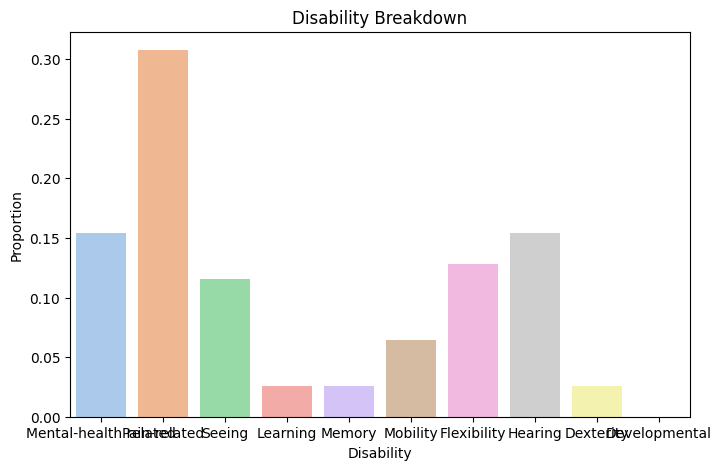

In [7]:
def main():
    
    df = pd.read_csv(file_path, delimiter = "|")
    
    print("\n=== Statistical Tests and Graphs ===\n")
    
    # == Sex Analysis ==
    analyze_and_plot(df, 'Sex', SEX_WEIGHTS, "Sex Distribution")

    # == Age Analysis== 
    df['Age_Category'] = df['Age'].apply(categorize_age)
    expected_age_probs, age_groups = compute_expected_age_probs(df)
    # Ensure the Age_Category is ordered correctly
    df['Age_Category'] = pd.Categorical(df['Age_Category'], categories=age_groups, ordered=True)
    analyze_and_plot(df, 'Age_Category', expected_age_probs, "Age Distribution", order=age_groups)

    # == Ethnicity Analysis ==
    df["Ethnicity_Category"] = df["Ethnicity"].apply(categorize_ethnicity)
    analyze_and_plot(df, 'Ethnicity_Category', ETHNICITY_PROBABILITY, "Ethnicity Distribution", order=ETHNICITY_ORDER)
    
    # == Disability Analysis ==
    expected_disability_df = df.apply(compute_expected_disability, axis=1)
    expected_disability_avg = expected_disability_df.mean() * 100
    expected_data = [expected_disability_avg.get(cat, 0) for cat in DISABILITY_CATEGORIES]
    analyze_and_plot(
        df, 
        column='Disability', 
        expected_probs=expected_data, 
        title="Disability Breakdown", 
        chart_type='bar',
        order=DISABILITY_CATEGORIES
    )
    
if __name__ == "__main__":
    main()